# Rotational Analysis of Crowded Cluster NGC 3532

See make_lightcurve.ipynb for a demonstration of the problem with measuring rotation periods automatically in crowded clusters with TESS light curves. NGC 3532 is a rich cluster >400 pc away, ensuring that many cluster members will be too close to each other on the sky for accurate automatic period measurements. Signals from some targets will blend with and contaminate the light curves of other targets. We perform a rotational analysis of the cluster to address this issue. Crucial to this analysis is an existing rotation period catalog in the literature which serves as a point of comparison for our TESS period measurements (Fritzewski et al. 2021). We expand on this rotation period catalog using TESS light curves.

## Set up notebook

**Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')


# Plotting program
import matplotlib.pyplot as plt

# System
import os
import sys
from glob import glob

# Good for reading/writing data tables
import pandas as pd

# Better math, numbers, and array functions
import numpy as np

# Astropy
from astropy.timeseries import LombScargle
from astropy.io import fits, ascii
from astropy.table import Table, join

# Download TESS
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
import astropy.units as units

from astroquery.vizier import Vizier # then we import the Vizier() tool
from astroquery.xmatch import XMatch # ...and the Xmatch() tool

Could not import regions, which is required for some of the functionalities of this module.


**Path to catalog**

In [2]:
dir_catalog = 'Auto_results_2024Jan06.csv'

**Plotting**

In [3]:
#plotting
axis_width = 1.5
axis_fontsize = 20
number_fontsize = 17
legend_fontsize = 17
plot_width = 10

save_plots = False

**Define functions**

In [4]:
# Returns distances to all other members of a catalog for one member

def dist_form_arr(ra, dec, ra_arr, dec_arr):
  dist =  np.sqrt(np.sum([[np.square(ra_arr - ra)], [np.square(dec_arr - dec)]], axis = 0)[0])*3600
  return dist

## Automatic Periods

**Load full catalog**

In [5]:
full_catalog = ascii.read(dir_catalog, format = 'csv')


full_catalog

Gaia_DR3_Source,Gaia_DR2_Source,RA,Dec,Plx,e_Plx,pmRA,pmDE,e_pm,RUWE,Gmag,e_Gmag,bp_rp,e_bp_rp,RV,e_RV,RV_Gaia,e_RV_Gaia,RV_GES,e_RV_GES,RV_Dario,e_RV_Dario,Teff_TIC_model,Teff_Gaia_bprp,Source_Spec,Teff_Spec,logg_Spec,[Fe/H]_Spec,RV_Spec,Li_Spec,Vbroad_Spec,Prot,Prot_TESS,Member_Gaia,Member_CG,Member_Theia,Member_DJF,Member_Hunt,Member_Curtis,Binary_Astrom,Binary_Spec,Binary_Phot,d_Plx,d_pm,d_RV,d_CMD,Done,N_Sectors_Cycle1,N_Sectors_Cycle3,N_Sectors_Cycle5,LS_Power_Cycle1,LS_Period_Cycle1,LS_Power_Cycle1_rapid,LS_Period_Cycle1_rapid,LS_Power_Cycle1_slow,LS_Period_Cycle1_slow,LS_Power_Cycle3,LS_Period_Cycle3,LS_Power_Cycle3_rapid,LS_Period_Cycle3_rapid,LS_Power_Cycle3_slow,LS_Period_Cycle3_slow,LS_Power_Cycle5,LS_Period_Cycle5,LS_Power_Cycle5_rapid,LS_Period_Cycle5_rapid,LS_Power_Cycle5_slow,LS_Period_Cycle5_slow,Possible_Blend_Cycle1,Possible_Blend_Cycle3,Possible_Blend_Cycle5
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
5241875613368612864,5241875613368612864,164.62269364708,-61.81945583644,2.1365,0.0237,-10.031,6.2,0.0367967389859482,1.805,13.38852,0.002805,0.963757,0.005140401929810548,nan,nan,5.65,4.13,nan,nan,nan,nan,5468.936970015048,5435.9,...,nan,nan,nan,nan,nan,nan,nan,nan,0,0,1,0,0,0,0,0,0,nan,nan,nan,nan,2,2,1,2,0.2317698057758105,5.6322771267058425,0.02065152517652091,2.972972802877675,0.2317698057758105,5.6322771267058425,0.15027049258278008,5.381001104177192,0.011823093144577348,2.4882229574941666,0.15027049258278008,5.381001104177192,0.18325065411056868,5.217758215543319,0.007605488915075415,2.996812694680618,0.18325065411056868,5.217758215543319,0,0,0
5242166605985236096,5242166605985236096,162.80777072131,-60.81534426769,1.8535,0.0795,-9.411,5.557,0.1380326048439281,0.996,17.599751,0.002984,2.436581,0.0297864225612946,nan,nan,nan,nan,nan,nan,nan,nan,3570.9766137006345,3553.0,...,nan,nan,nan,nan,nan,nan,nan,nan,0,0,1,0,0,0,0,0,0,nan,nan,nan,nan,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0
5254207563975333888,5254207563975333888,161.15592359814,-60.45828316557,2.3918,0.0943,-11.129,6.626,0.15297058540778355,1.007,17.952528,0.003138,2.616352,0.03583808058476347,nan,nan,nan,nan,nan,nan,nan,nan,3407.9715068309297,3479.4,...,nan,nan,nan,nan,nan,nan,nan,nan,0,0,1,0,0,0,0,0,0,nan,nan,nan,nan,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0
5334364504244265088,5334364504244265088,171.1654578368,-61.53890036366,1.9586,0.0513,-9.63,3.513,0.07574298647399638,2.795,14.750587,0.002849,1.173842,0.005351989910304391,nan,nan,50.43,14.25,nan,nan,nan,nan,4953.112274174114,5153.0,...,nan,nan,nan,nan,nan,nan,nan,nan,0,0,1,0,0,0,0,0,0,nan,nan,nan,nan,2,2,2,0,0.4835234847673348,0.6108014255776041,0.4835234847673348,0.6108014255776041,0.004361252779182042,7.931238725431774,0.28067995692308595,0.6108014255776041,0.28067995692308595,0.6108014255776041,0.010982037572988948,6.987759182805022,nan,nan,nan,nan,nan,nan,0,0,0
5334411577110134016,5334411577110134016,172.83056655771,-61.4056998483,2.0708,0.0243,-10.55,4.08,0.03606937759374287,0.986,15.414752,0.00278,1.485167,0.005741809209648123,nan,nan,nan,nan,nan,nan,nan,nan,4382.893888601828,4606.0,...,nan,nan,nan,nan,nan,nan,nan,nan,0,0,1,0,0,0,0,0,0,nan,nan,nan,nan,2,2,2,0,0.24020192969231444,27.476787584356142,0.004855396196088211,1.6388067520137959,0.24020192969231444,27.476787584356142,0.026310468185345756,10.10164200735063,0.0025668836281896473,0.135304951280008,0.026310468185345756,10.10164200735063,nan,nan,nan,nan,nan,nan,0,0,0
533

In [6]:
# Check what cycles have data for our targets

cycle1 = 0
cycle3 = 0
cycle5 = 0

cycle13 = 0
cycle15 = 0
cycle35 = 0

cycle135 = 0

cycle1_only = 0
cycle3_only = 0
cycle5_only = 0

for i in range(0, len(full_catalog)):
  if(np.isnan(full_catalog['LS_Period_Cycle1'][i]) == False):
    cycle1 += 1
    if(np.isnan(full_catalog['LS_Period_Cycle3'][i]) == False and np.isnan(full_catalog['LS_Period_Cycle5'][i]) == False):
      cycle135 += 1
    elif(np.isnan(full_catalog['LS_Period_Cycle3'][i]) == False):
      cycle13 += 1
    elif(np.isnan(full_catalog['LS_Period_Cycle5'][i]) == False):
      cycle15 += 1
    else:
      cycle1_only += 1
  if(np.isnan(full_catalog['LS_Period_Cycle3'][i]) == False):
    cycle3 += 1
    if(np.isnan(full_catalog['LS_Period_Cycle5'][i]) == False and np.isnan(full_catalog['LS_Period_Cycle1'][i])):
      cycle35 += 1
    elif(np.isnan(full_catalog['LS_Period_Cycle5'][i]) and np.isnan(full_catalog['LS_Period_Cycle1'][i])):
      cycle3_only += 1
  if(np.isnan(full_catalog['LS_Period_Cycle5'][i]) == False):
    cycle5 += 1
    if(np.isnan(full_catalog['LS_Period_Cycle3'][i]) and np.isnan(full_catalog['LS_Period_Cycle1'][i])):
      cycle5_only += 1

print('Cycle 1 Periods total: ' + str(cycle1))
print('Cycle 3 Periods total: ' + str(cycle3))
print('Cycle 5 Periods total: ' + str(cycle5))

print('Cycle 1 & 3 Periods only: ' + str(cycle13))
print('Cycle 1 & 5 Periods only: ' + str(cycle15))
print('Cycle 3 & 5 Periods only: ' + str(cycle35))

print('Cycle 1, 3, & 5 Periods: ' + str(cycle135))

print('Cycle 1 Periods only: ' + str(cycle1_only))
print('Cycle 3 Periods only: ' + str(cycle3_only))
print('Cycle 5 Periods only: ' + str(cycle5_only))

Cycle 1 Periods total: 2110
Cycle 3 Periods total: 1667
Cycle 5 Periods total: 2111
Cycle 1 & 3 Periods only: 8
Cycle 1 & 5 Periods only: 452
Cycle 3 & 5 Periods only: 9
Cycle 1, 3, & 5 Periods: 1650
Cycle 1 Periods only: 0
Cycle 3 Periods only: 0
Cycle 5 Periods only: 0


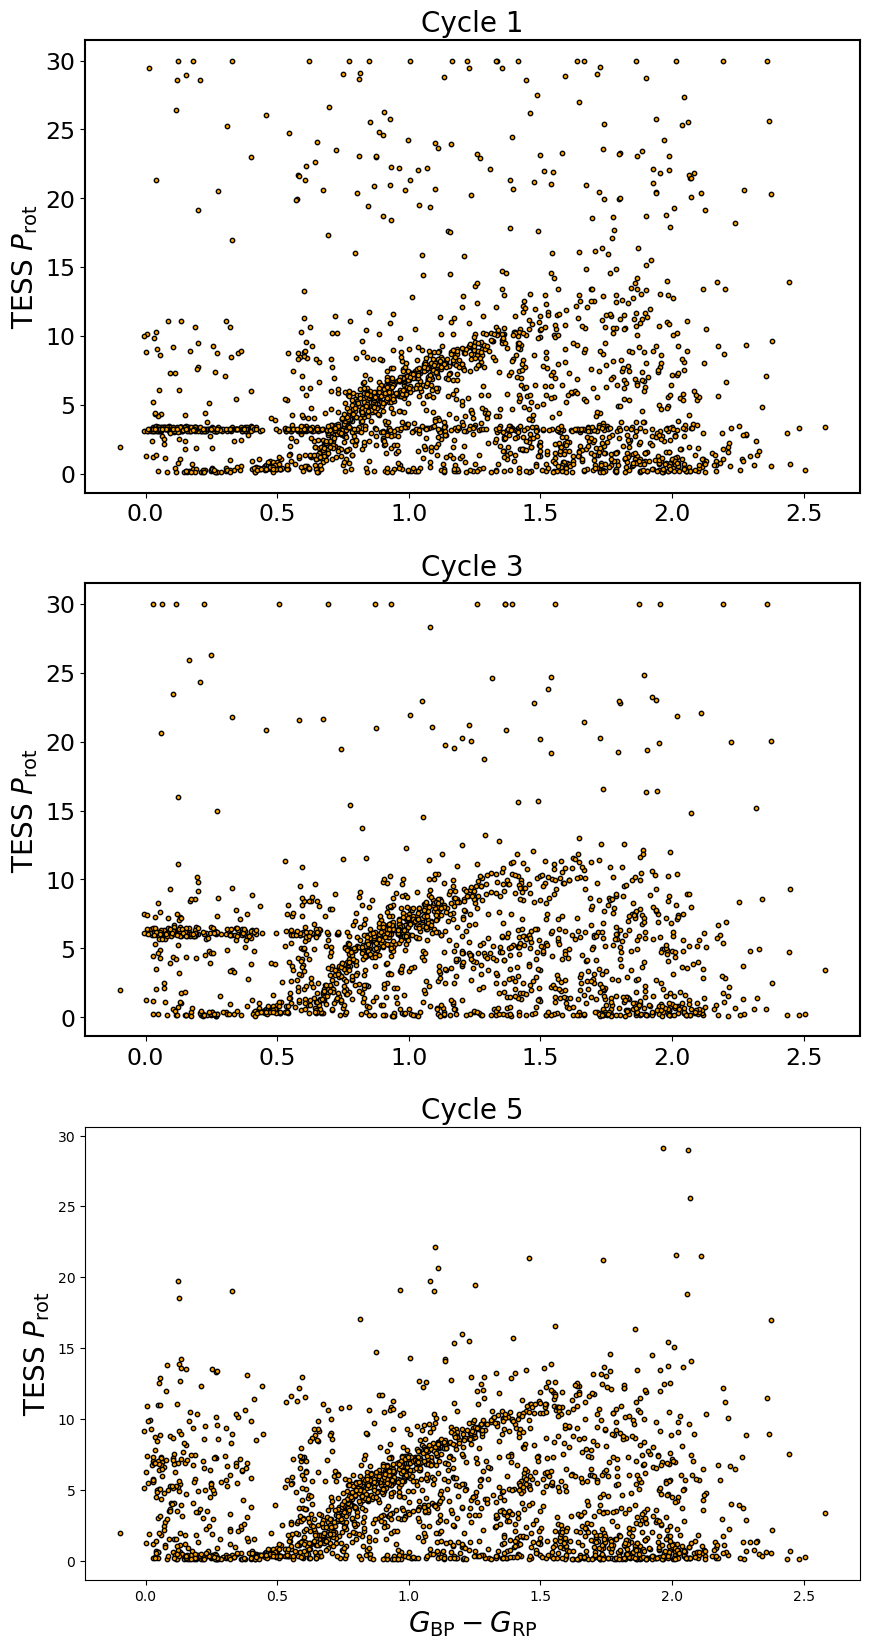

In [21]:
# Plot color-period diagrams (CPDs) for each cycle with automatically measured periods

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10, 20))

#ax1.axhline(y = 3.5)
#ax1.axhline(y = 3)


ax1.scatter(full_catalog['bp_rp'], full_catalog['LS_Period_Cycle1'], c = 'orange', edgecolor = 'black', s = 10)
ax1.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax1.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax1.set_title('Cycle 1', fontsize = 20)

ax2.scatter(full_catalog['bp_rp'], full_catalog['LS_Period_Cycle3'], c = 'orange', edgecolor = 'black', s = 10)
ax2.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax2.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax2.set_title('Cycle 3', fontsize = 20)

ax3.scatter(full_catalog['bp_rp'], full_catalog['LS_Period_Cycle5'], c = 'orange', edgecolor = 'black', s = 10)
ax3.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
ax3.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax3.set_title('Cycle 5', fontsize = 20)

# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "Full_Member_CP_H_B.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)


plt.show()

Notice the high number of erroneous measurements in each cycle. We see a well populated slow rotating sequence in each cycle as we expect, but there is a lot of scatter both above and below this sequence. Earlier type stars than mid-F (BP-RP < 0.5) do not have a convective envelope and are outside of the scope of this analysis, but their signals can still contaminate light curves for our targets of interest. Periods longer than ~15 days measured from TESS light curves are often innacurate because of the length of TESS sectors (27 days). Notice the build up of rapid periods (<2 days). Rapid periods have a strength bias and are usually measured with higher power than longer periods. Also notice the systematic error in Cycle 1 (stripe of periods 3.0-3.5 days). Also notice the half period harmonic sequence below the slow rotating sequence. We address all of these problems as well as the blending problem in the following analysis.

## Identify membership outliers

In [8]:
plx_std = np.std(full_catalog['Plx'])
plx_mean = np.mean(full_catalog['Plx'])

print(plx_mean, plx_std)

2.060639526090245 0.2672810396990097


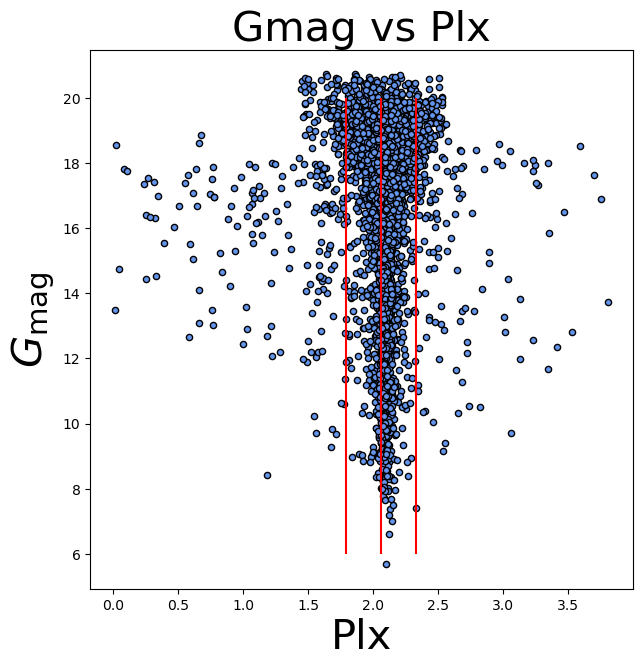

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))


ax.scatter(full_catalog['Plx'], full_catalog['Gmag'], c='cornflowerblue', edgecolor = 'black', s = 20)
ax.set_ylabel(r'$G_{\rm mag}$', fontsize = 30)
ax.set_xlabel('Plx', fontsize = 30)
ax.set_title('Gmag vs Plx', fontsize = 30)

ax.vlines(plx_mean, 6, 20, color = 'r')
ax.vlines(plx_mean-plx_std, 6, 20, color = 'r')
ax.vlines(plx_mean+plx_std, 6, 20, color = 'r')



# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "3532_CPD_Marked.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)


plt.show()

In [11]:
full_catalog['Plx_Outlier'] = np.zeros(len(full_catalog))

plx_outliers1 = np.where(full_catalog['Plx']>plx_mean+plx_std)[0]
plx_outliers2 = np.where(full_catalog['Plx']<plx_mean-plx_std)[0]
plx_outliers = np.concatenate((plx_outliers1, plx_outliers2))
plx_outliers = np.sort(plx_outliers)


for i in plx_outliers:
  full_catalog['Plx_Outlier'][i] = 1

print(len(plx_outliers))


530


In [13]:
rv_std = np.nanstd(full_catalog['RV_Gaia'])
rv_mean = np.nanmean(full_catalog['RV_Gaia'])

print(rv_mean, rv_std)

4.773764798737175 10.159968730022527


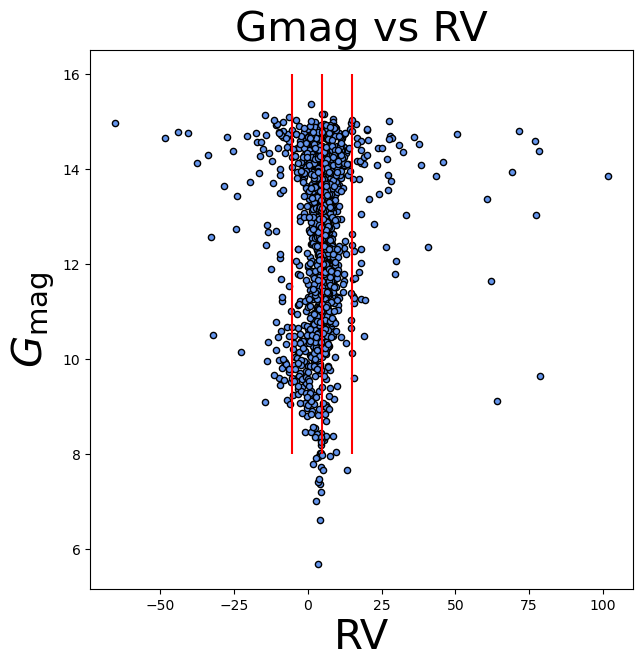

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))


ax.scatter(full_catalog['RV_Gaia'], full_catalog['Gmag'], c='cornflowerblue', edgecolor = 'black', s = 20)
ax.set_ylabel(r'$G_{\rm mag}$', fontsize = 30)
ax.set_xlabel('RV', fontsize = 30)
ax.set_title('Gmag vs RV', fontsize = 30)


ax.vlines(rv_mean, 8, 16, color = 'r')
ax.vlines(rv_mean-rv_std, 8, 16, color = 'r')
ax.vlines(rv_mean+rv_std, 8, 16, color = 'r')


# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "3532_CPD_Marked.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)


plt.show()

In [15]:
full_catalog['RV_Outlier'] = np.zeros(len(full_catalog))

rv_outliers1 = np.where(full_catalog['RV_Gaia']>rv_mean+rv_std)[0]
rv_outliers2 = np.where(full_catalog['RV_Gaia']<rv_mean-rv_std)[0]
rv_outliers = np.concatenate((rv_outliers1, rv_outliers2))

rv_outliers = np.sort(rv_outliers)

for i in rv_outliers:
  full_catalog['RV_Outlier'][i] = 1

print(len(rv_outliers))

160


In [17]:
pmRA_std = np.std(full_catalog['pmRA'])
pmRA_mean = np.mean(full_catalog['pmRA'])

pmDec_std = np.std(full_catalog['pmDE'])
pmDec_mean = np.mean(full_catalog['pmDE'])

print(pmRA_mean, pmRA_std)
print(pmDec_mean, pmDec_std)

-10.444461305772624 1.0372877925923272
5.180130073103101 0.7314002043041367


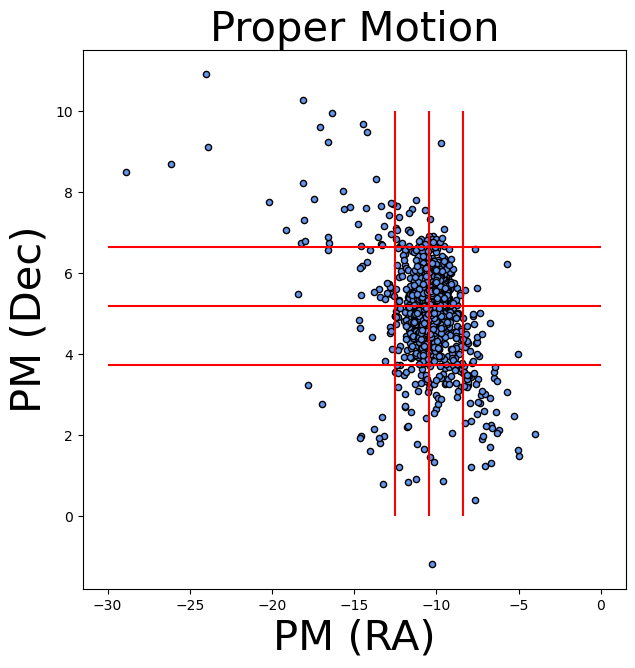

In [18]:


fig, ax = plt.subplots(figsize=(7, 7))


ax.scatter(full_catalog['pmRA'], full_catalog['pmDE'], c='cornflowerblue', edgecolor = 'black', s = 20)
ax.set_ylabel('PM (Dec)', fontsize = 30)
ax.set_xlabel('PM (RA)', fontsize = 30)
ax.set_title('Proper Motion', fontsize = 30)

ax.vlines(pmRA_mean, 0, 10, color = 'r')
ax.vlines(pmRA_mean-2*pmRA_std, 0, 10, color = 'r')
ax.vlines(pmRA_mean+2*pmRA_std, 0, 10, color = 'r')

ax.hlines(pmDec_mean, -30, 0, color = 'r')
ax.hlines(pmDec_mean-2*pmDec_std, -30, 0, color = 'r')
ax.hlines(pmDec_mean+2*pmDec_std, -30, 0, color = 'r')

# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "3532_CPD_Marked.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)


plt.show()

In [19]:
full_catalog['PM_Outlier'] = np.zeros(len(full_catalog))

pm_outliers1 = np.where(full_catalog['pmRA']>pmRA_mean+2*pmRA_std)[0]
pm_outliers2 = np.where(full_catalog['pmRA']<pmRA_mean-2*pmRA_std)[0]
pm_outliers3 = np.where(full_catalog['pmDE']>pmDec_mean+2*pmDec_std)[0]
pm_outliers4 = np.where(full_catalog['pmDE']<pmDec_mean-2*pmDec_std)[0]
pm_outliers = np.concatenate((pm_outliers1, pm_outliers2, pm_outliers3, pm_outliers4))

pm_outliers = np.sort(pm_outliers)


for i in pm_outliers:
  full_catalog['PM_Outlier'][i] = 1

print(len(pm_outliers))

338


**Identify binary candidates using RUWE**

In [39]:
full_catalog['Binary_Candidate'] = np.zeros(len(full_catalog))
binary_candidates = np.where(full_catalog['RUWE'] > 1.4)[0]


for i in binary_candidates:
  full_catalog['Binary_Candidate'][i] = 1

print(len(binary_candidates))

402


## Period Quality Analysis

**Identify periods with blended light curves**

In [23]:
quality_period_table = Table([full_catalog['LS_Period_Cycle1'], full_catalog['LS_Period_Cycle3'], full_catalog['LS_Period_Cycle5'],
                              full_catalog['LS_Power_Cycle1'], full_catalog['LS_Power_Cycle3'], full_catalog['LS_Power_Cycle5']])

# Targets will be supported in classes based on how many quality periods they have

quality_period_table['Class'] = np.zeros(len(full_catalog))
quality_period_table['Prot_Final'] = np.zeros(len(full_catalog))
quality_period_table['Power_Final'] = np.zeros(len(full_catalog))

for i in range(0, len(full_catalog)):

  distances = dist_form_arr(full_catalog['RA'][i],full_catalog['Dec'][i],full_catalog['RA'],full_catalog['Dec'])

  rot_index = np.where(distances<120)[0]

  for j in rot_index:

    if(i!=j and (abs(full_catalog['LS_Period_Cycle1'][j] - full_catalog['LS_Period_Cycle1'][i])/full_catalog['LS_Period_Cycle1'][i])*100<1
        and full_catalog['Gmag'][j]<full_catalog['Gmag'][i]
        ):
      quality_period_table['LS_Power_Cycle1'][i] = -1

    if(i!=j and (abs(full_catalog['LS_Period_Cycle3'][j] - full_catalog['LS_Period_Cycle3'][i])/full_catalog['LS_Period_Cycle3'][i])*100<1
        and full_catalog['Gmag'][j]<full_catalog['Gmag'][i]
        ):
      quality_period_table['LS_Power_Cycle3'][i] = -1

    if(i!=j and (abs(full_catalog['LS_Period_Cycle5'][j] - full_catalog['LS_Period_Cycle5'][i])/full_catalog['LS_Period_Cycle5'][i])*100<1
        and full_catalog['Gmag'][j]<full_catalog['Gmag'][i]
        ):
      quality_period_table['LS_Power_Cycle5'][i] = -1


  if(quality_period_table['LS_Period_Cycle1'][i] > 3.0 and quality_period_table['LS_Period_Cycle1'][i] < 3.5):
    quality_period_table['LS_Period_Cycle1'][i] = np.nan




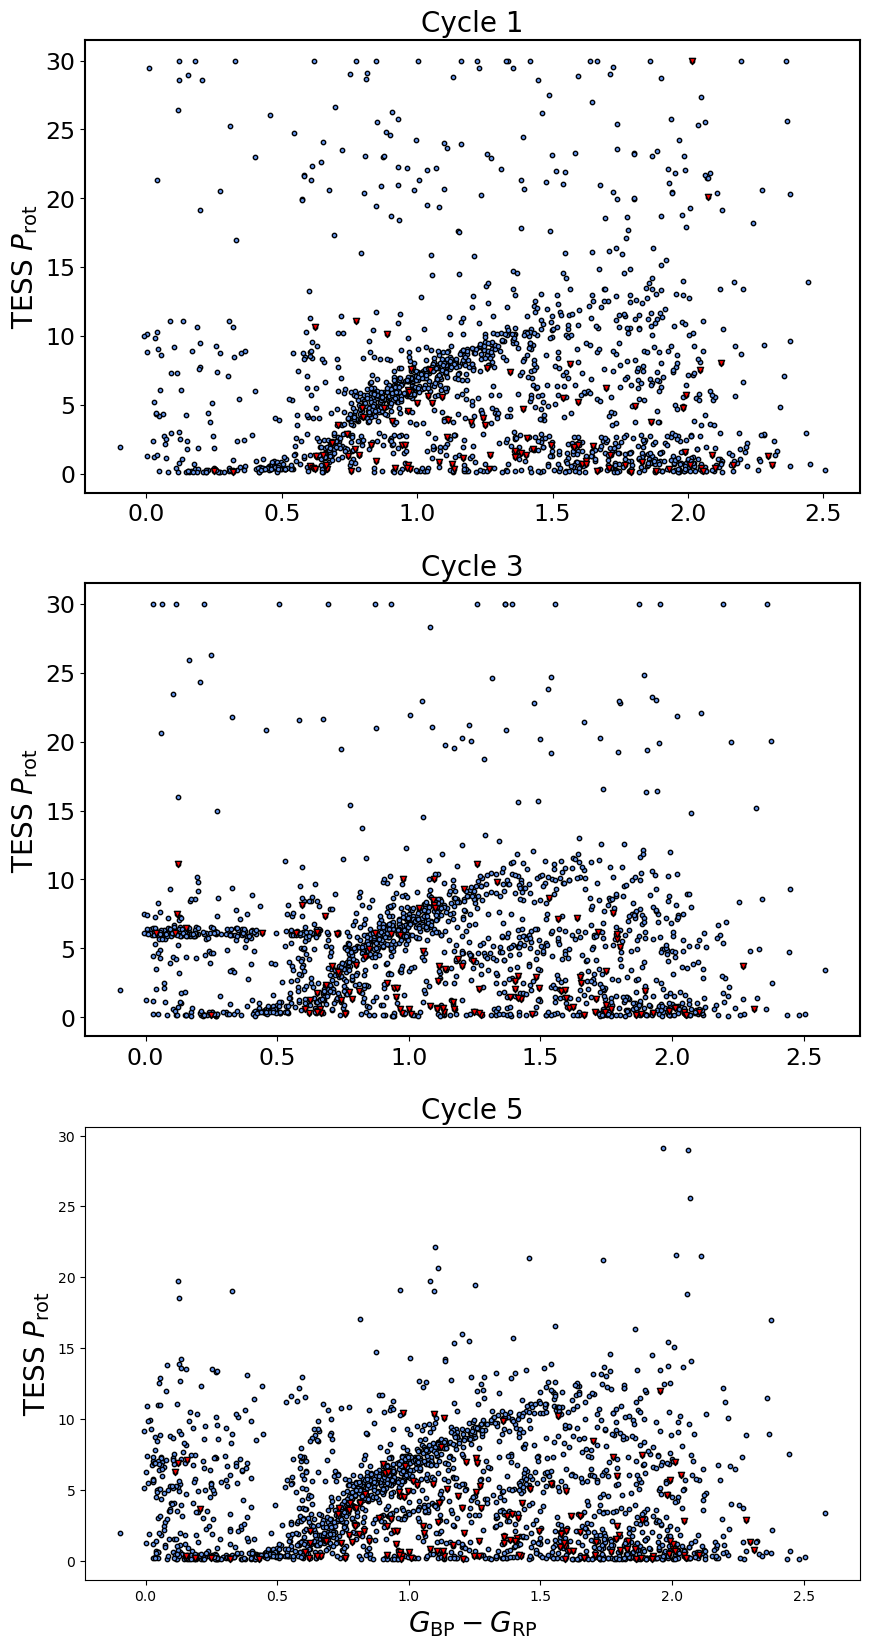

In [24]:
# Plot CPDs with stars with blended light curves identified

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10, 20))

#ax1.axhline(y = 3.5)
#ax1.axhline(y = 3)

c1_blended = np.where(quality_period_table['LS_Power_Cycle1'] == -1)[0]
c3_blended = np.where(quality_period_table['LS_Power_Cycle3'] == -1)[0]
c5_blended = np.where(quality_period_table['LS_Power_Cycle5'] == -1)[0]


ax1.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle1'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax1.scatter(full_catalog['bp_rp'][c1_blended], quality_period_table['LS_Period_Cycle1'][c1_blended], c = 'red', edgecolor = 'black', s = 20, marker = 'v')
ax1.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax1.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax1.set_title('Cycle 1', fontsize = 20)

ax2.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle3'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax2.scatter(full_catalog['bp_rp'][c3_blended], quality_period_table['LS_Period_Cycle3'][c3_blended], c = 'red', edgecolor = 'black', s = 20, marker = 'v')
ax2.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax2.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax2.set_title('Cycle 3', fontsize = 20)

ax3.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle5'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax3.scatter(full_catalog['bp_rp'][c5_blended], quality_period_table['LS_Period_Cycle5'][c5_blended], c = 'red', edgecolor = 'black', s = 20, marker = 'v')
ax3.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
ax3.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax3.set_title('Cycle 5', fontsize = 20)

# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "Full_Member_CP_H_B.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)


plt.show()

**Identify measured periods that are likely the harmonic period**

In [25]:
quality_period_table['Cycle1_Doubled'] = np.zeros(len(quality_period_table))
quality_period_table['Cycle3_Doubled'] = np.zeros(len(quality_period_table))
quality_period_table['Cycle5_Doubled'] = np.zeros(len(quality_period_table))

for i in range(0, len(full_catalog)):

  if(quality_period_table['LS_Power_Cycle1'][i] == -1):
    quality_period_table['LS_Period_Cycle1'][i] = np.nan

  if(quality_period_table['LS_Power_Cycle3'][i] == -1):
    quality_period_table['LS_Period_Cycle3'][i] = np.nan

  if(quality_period_table['LS_Power_Cycle5'][i] == -1):
    quality_period_table['LS_Period_Cycle5'][i] = np.nan


  if(((abs(quality_period_table['LS_Period_Cycle1'][i]*2 -
          quality_period_table['LS_Period_Cycle3'][i])/quality_period_table['LS_Period_Cycle3'][i])*100
     < 20 or (abs(quality_period_table['LS_Period_Cycle1'][i]*2 -
                  quality_period_table['LS_Period_Cycle5'][i])/quality_period_table['LS_Period_Cycle5'][i])*100 < 20)
  and quality_period_table['LS_Period_Cycle1'][i]*2 < 15):
    quality_period_table['LS_Period_Cycle1'][i] = quality_period_table['LS_Period_Cycle1'][i]*2
    quality_period_table['Cycle1_Doubled'][i] = 1

  if(((abs(quality_period_table['LS_Period_Cycle3'][i]*2 -
          quality_period_table['LS_Period_Cycle1'][i])/quality_period_table['LS_Period_Cycle1'][i])*100
     < 20 or (abs(quality_period_table['LS_Period_Cycle3'][i]*2 -
                  quality_period_table['LS_Period_Cycle5'][i])/quality_period_table['LS_Period_Cycle5'][i])*100 < 20)
  and quality_period_table['LS_Period_Cycle3'][i]*2 < 15):
    quality_period_table['LS_Period_Cycle3'][i] = quality_period_table['LS_Period_Cycle3'][i]*2
    quality_period_table['Cycle3_Doubled'][i] = 1

  if(((abs(quality_period_table['LS_Period_Cycle5'][i]*2 -
          quality_period_table['LS_Period_Cycle3'][i])/quality_period_table['LS_Period_Cycle3'][i])*100
     < 20 or (abs(quality_period_table['LS_Period_Cycle5'][i]*2 -
                  quality_period_table['LS_Period_Cycle1'][i])/quality_period_table['LS_Period_Cycle1'][i])*100 < 20)
  and quality_period_table['LS_Period_Cycle5'][i]*2 < 15):
    quality_period_table['LS_Period_Cycle5'][i] = quality_period_table['LS_Period_Cycle5'][i]*2
    quality_period_table['Cycle5_Doubled'][i] = 1



print(len(np.where(full_catalog['LS_Period_Cycle1']>0)[0]))
print(len(np.where(full_catalog['LS_Period_Cycle3']>0)[0]))
print(len(np.where(full_catalog['LS_Period_Cycle5']>0)[0]))

print(len(np.where(quality_period_table['LS_Period_Cycle1']>0)[0]))
print(len(np.where(quality_period_table['LS_Period_Cycle3']>0)[0]))
print(len(np.where(quality_period_table['LS_Period_Cycle5']>0)[0]))

quality_period_table


2110
1667
2111
1567
1543
1946


LS_Period_Cycle1,LS_Period_Cycle3,LS_Period_Cycle5,LS_Power_Cycle1,LS_Power_Cycle3,LS_Power_Cycle5,Class,Prot_Final,Power_Final,Cycle1_Doubled,Cycle3_Doubled,Cycle5_Doubled
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5.6322771267058425,5.381001104177192,5.217758215543319,0.2317698057758105,0.15027049258278008,0.18325065411056868,0.0,0.0,0.0,0.0,0.0,0.0
nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0
nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0
0.6108014255776041,0.6108014255776041,nan,0.4835234847673348,0.28067995692308595,nan,0.0,0.0,0.0,0.0,0.0,0.0
27.476787584356142,10.10164200735063,nan,0.24020192969231444,0.026310468185345756,nan,0.0,0.0,0.0,0.0,0.0,0.0
nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0
10.090122761348857,11.270993922431433,15.709396890609574,0.5011250299565889,0.06260820208053743,0.019157342045253184,0.0,0.0,0.0,0.0,0.0,0.0


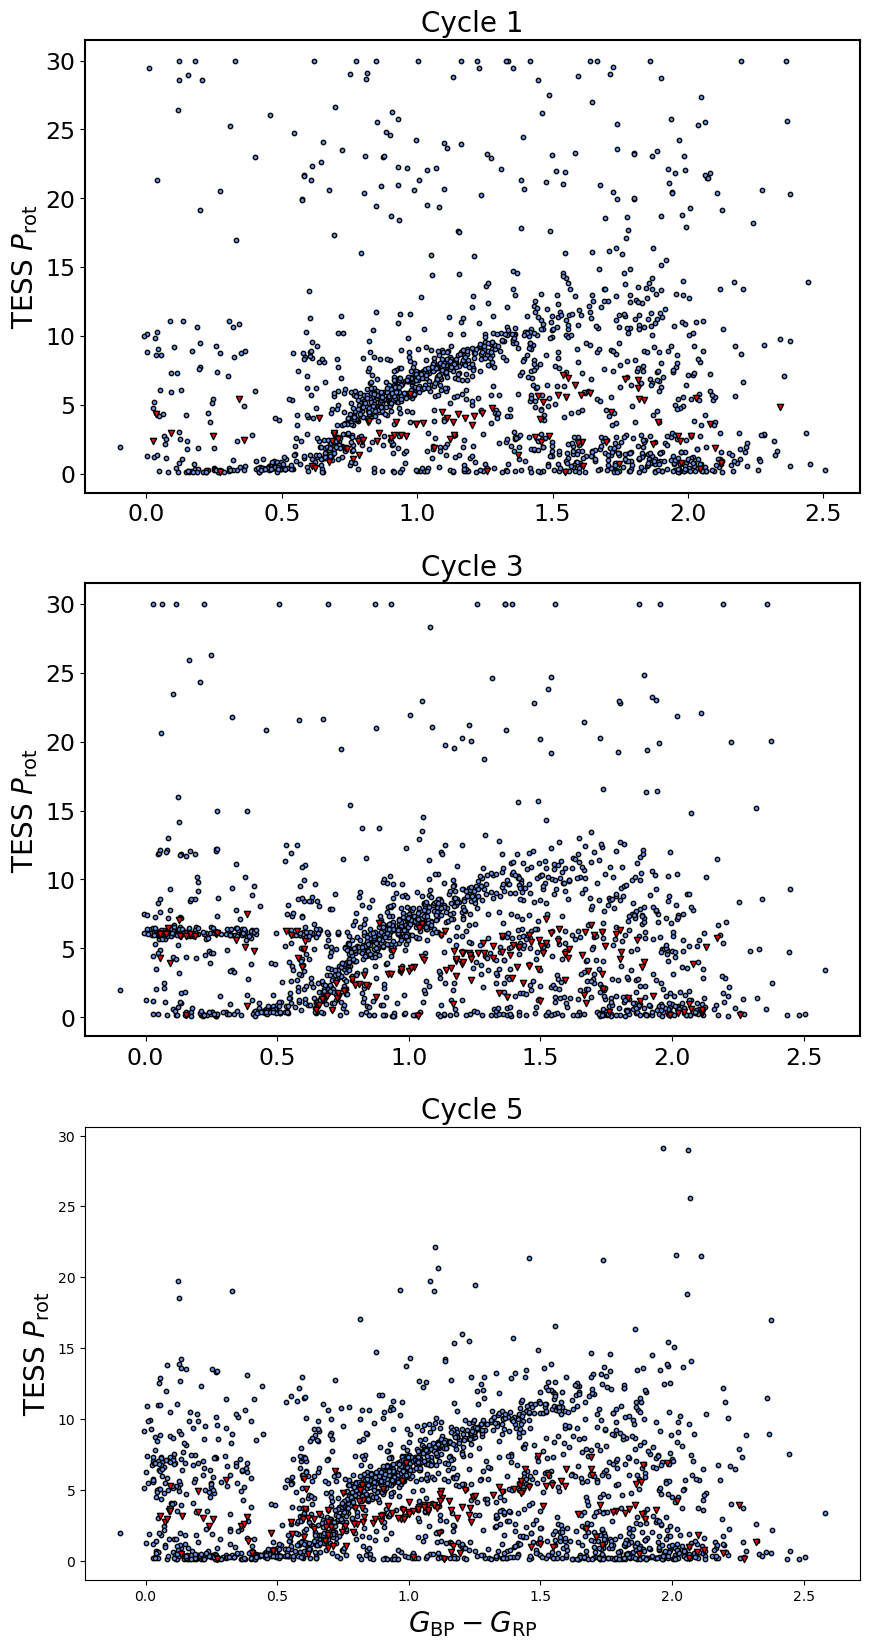

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10, 20))

#ax1.axhline(y = 3.5)
#ax1.axhline(y = 3)

c1_double = np.where(quality_period_table['Cycle1_Doubled'] == 1)[0]
c3_double = np.where(quality_period_table['Cycle3_Doubled'] == 1)[0]
c5_double = np.where(quality_period_table['Cycle5_Doubled'] == 1)[0]


ax1.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle1'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax1.scatter(full_catalog['bp_rp'][c1_double], full_catalog['LS_Period_Cycle1'][c1_double], c = 'red', edgecolor = 'black', s = 20, marker = 'v')
ax1.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax1.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax1.set_title('Cycle 1', fontsize = 20)

ax2.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle3'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax2.scatter(full_catalog['bp_rp'][c3_double], full_catalog['LS_Period_Cycle3'][c3_double], c = 'red', edgecolor = 'black', s = 20, marker = 'v')
ax2.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax2.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax2.set_title('Cycle 3', fontsize = 20)

ax3.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle5'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax3.scatter(full_catalog['bp_rp'][c5_double], full_catalog['LS_Period_Cycle5'][c5_double], c = 'red', edgecolor = 'black', s = 20, marker = 'v')
ax3.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
ax3.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax3.set_title('Cycle 5', fontsize = 20)

# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "Full_Member_CP_H_B.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)


plt.show()

**Identify stars with otherwise erroneous rapid periods**

If a rapid period is present in one cycle and absent in another, this is most likely an error considering the bias for rapid periods using TESS and Lomb Scargle. We remeasure these periods only checking for longer periods.

In [27]:
quality_period_table['Cycle1_Slowed'] = np.zeros(len(quality_period_table))
quality_period_table['Cycle3_Slowed'] = np.zeros(len(quality_period_table))
quality_period_table['Cycle5_Slowed'] = np.zeros(len(quality_period_table))




for i in range(0, len(full_catalog)):



  if((quality_period_table['LS_Period_Cycle1'][i] < 4) and
   (quality_period_table['LS_Period_Cycle3'][i] > quality_period_table['LS_Period_Cycle1'][i]*1.2 or
    quality_period_table['LS_Period_Cycle5'][i] > quality_period_table['LS_Period_Cycle1'][i]*1.2)):
   quality_period_table['LS_Period_Cycle1'][i] = full_catalog['LS_Period_Cycle1_slow'][i]
   quality_period_table['LS_Power_Cycle1'][i] = full_catalog['LS_Power_Cycle1_slow'][i]
   quality_period_table['Cycle1_Slowed'][i] = 1

  if((quality_period_table['LS_Period_Cycle3'][i] < 4) and
   (quality_period_table['LS_Period_Cycle5'][i] > quality_period_table['LS_Period_Cycle3'][i]*1.2 or
    quality_period_table['LS_Period_Cycle1'][i] > quality_period_table['LS_Period_Cycle3'][i]*1.2)):
   quality_period_table['LS_Period_Cycle3'][i] = full_catalog['LS_Period_Cycle3_slow'][i]
   quality_period_table['LS_Power_Cycle3'][i] = full_catalog['LS_Power_Cycle3_slow'][i]
   quality_period_table['Cycle3_Slowed'][i] = 1

  if((quality_period_table['LS_Period_Cycle5'][i] < 4) and
   (quality_period_table['LS_Period_Cycle1'][i] > quality_period_table['LS_Period_Cycle5'][i]*1.2 or
    quality_period_table['LS_Period_Cycle3'][i] > quality_period_table['LS_Period_Cycle5'][i]*1.2)):
   quality_period_table['LS_Period_Cycle5'][i] = full_catalog['LS_Period_Cycle5_slow'][i]
   quality_period_table['LS_Power_Cycle5'][i] = full_catalog['LS_Power_Cycle5_slow'][i]
   quality_period_table['Cycle5_Slowed'][i] = 1

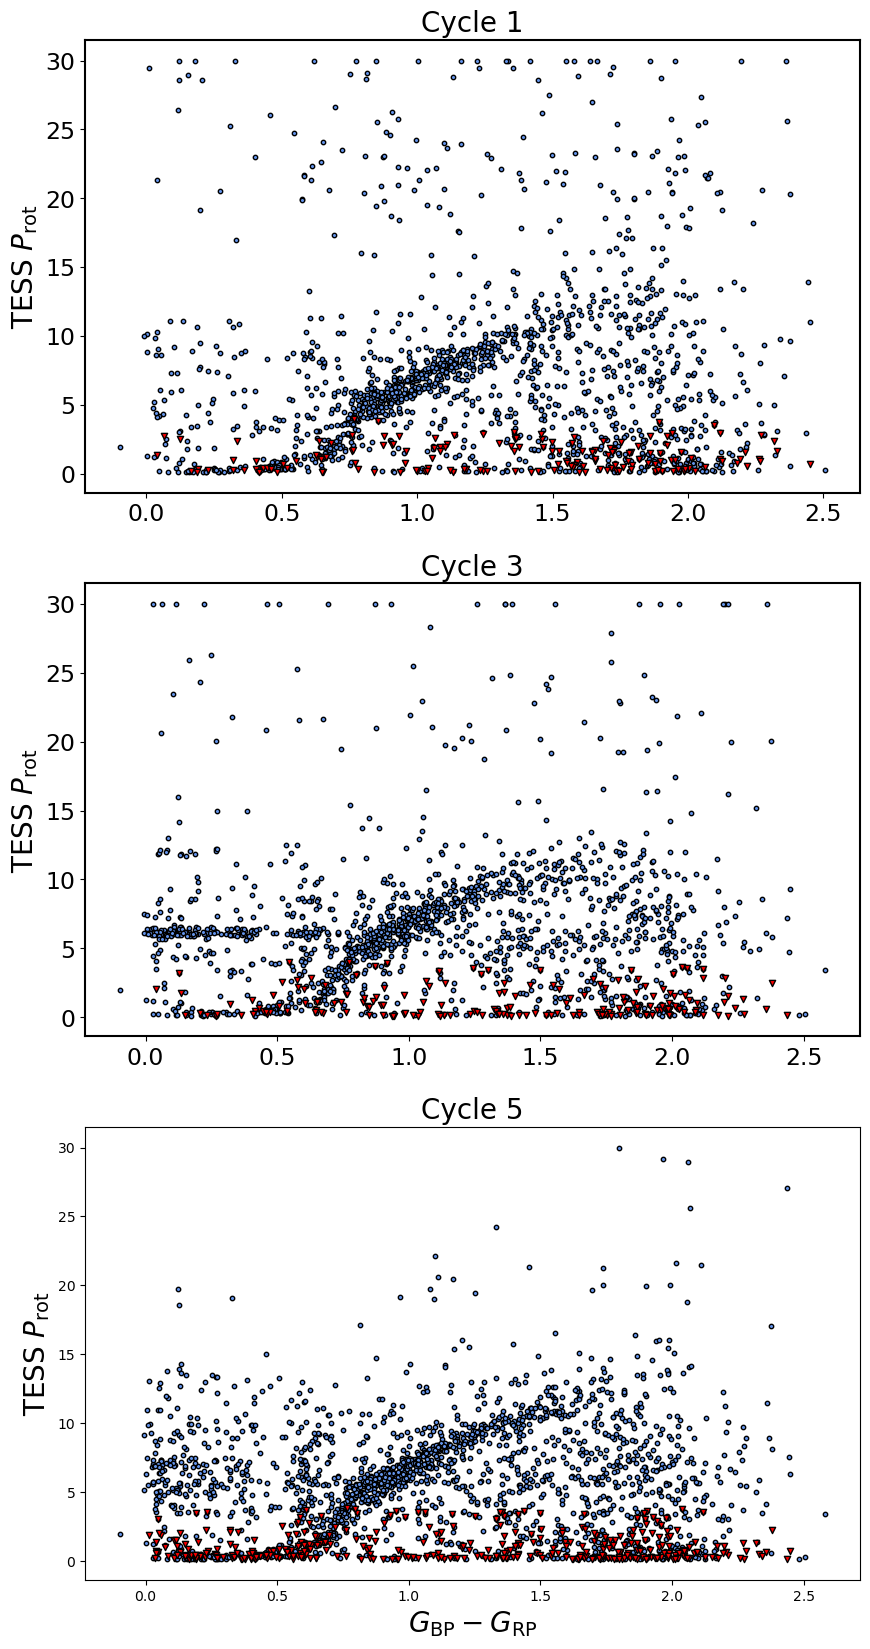

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10, 20))

#ax1.axhline(y = 3.5)
#ax1.axhline(y = 3)

c1_slowed = np.where(quality_period_table['Cycle1_Slowed'] == 1)[0]
c3_slowed = np.where(quality_period_table['Cycle3_Slowed'] == 1)[0]
c5_slowed = np.where(quality_period_table['Cycle5_Slowed'] == 1)[0]


ax1.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle1'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax1.scatter(full_catalog['bp_rp'][c1_slowed], full_catalog['LS_Period_Cycle1'][c1_slowed], c = 'red', edgecolor = 'black', s = 20, marker = 'v')
ax1.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax1.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax1.set_title('Cycle 1', fontsize = 20)

ax2.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle3'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax2.scatter(full_catalog['bp_rp'][c3_slowed], full_catalog['LS_Period_Cycle3'][c3_slowed], c = 'red', edgecolor = 'black', s = 20, marker = 'v')
ax2.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax2.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax2.set_title('Cycle 3', fontsize = 20)

ax3.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle5'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax3.scatter(full_catalog['bp_rp'][c5_slowed], full_catalog['LS_Period_Cycle5'][c5_slowed], c = 'red', edgecolor = 'black', s = 20, marker = 'v')
ax3.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
ax3.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax3.set_title('Cycle 5', fontsize = 20)

# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "Full_Member_CP_H_B.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)


plt.show()

**Remove periods for early type stars and especially long periods**

In [29]:

for i in range(0, len(full_catalog)):


  if(quality_period_table['LS_Period_Cycle1'][i] > 15):
    quality_period_table['LS_Period_Cycle1'][i] = np.nan

  if(quality_period_table['LS_Period_Cycle3'][i] > 15):
    quality_period_table['LS_Period_Cycle3'][i] = np.nan

  if(quality_period_table['LS_Period_Cycle5'][i] > 15):
    quality_period_table['LS_Period_Cycle5'][i] = np.nan

  if(full_catalog['bp_rp'][i] < 0.5):
    quality_period_table['LS_Period_Cycle1'][i] = np.nan
    quality_period_table['LS_Period_Cycle3'][i] = np.nan
    quality_period_table['LS_Period_Cycle5'][i] = np.nan

print(len(np.where(full_catalog['LS_Period_Cycle1']>0)[0]))
print(len(np.where(full_catalog['LS_Period_Cycle3']>0)[0]))
print(len(np.where(full_catalog['LS_Period_Cycle5']>0)[0]))

print(len(np.where(quality_period_table['LS_Period_Cycle1']>0)[0]))
print(len(np.where(quality_period_table['LS_Period_Cycle3']>0)[0]))
print(len(np.where(quality_period_table['LS_Period_Cycle5']>0)[0]))



2110
1667
2111
1255
1192
1575


**Plot CPDs after period quality analysis**

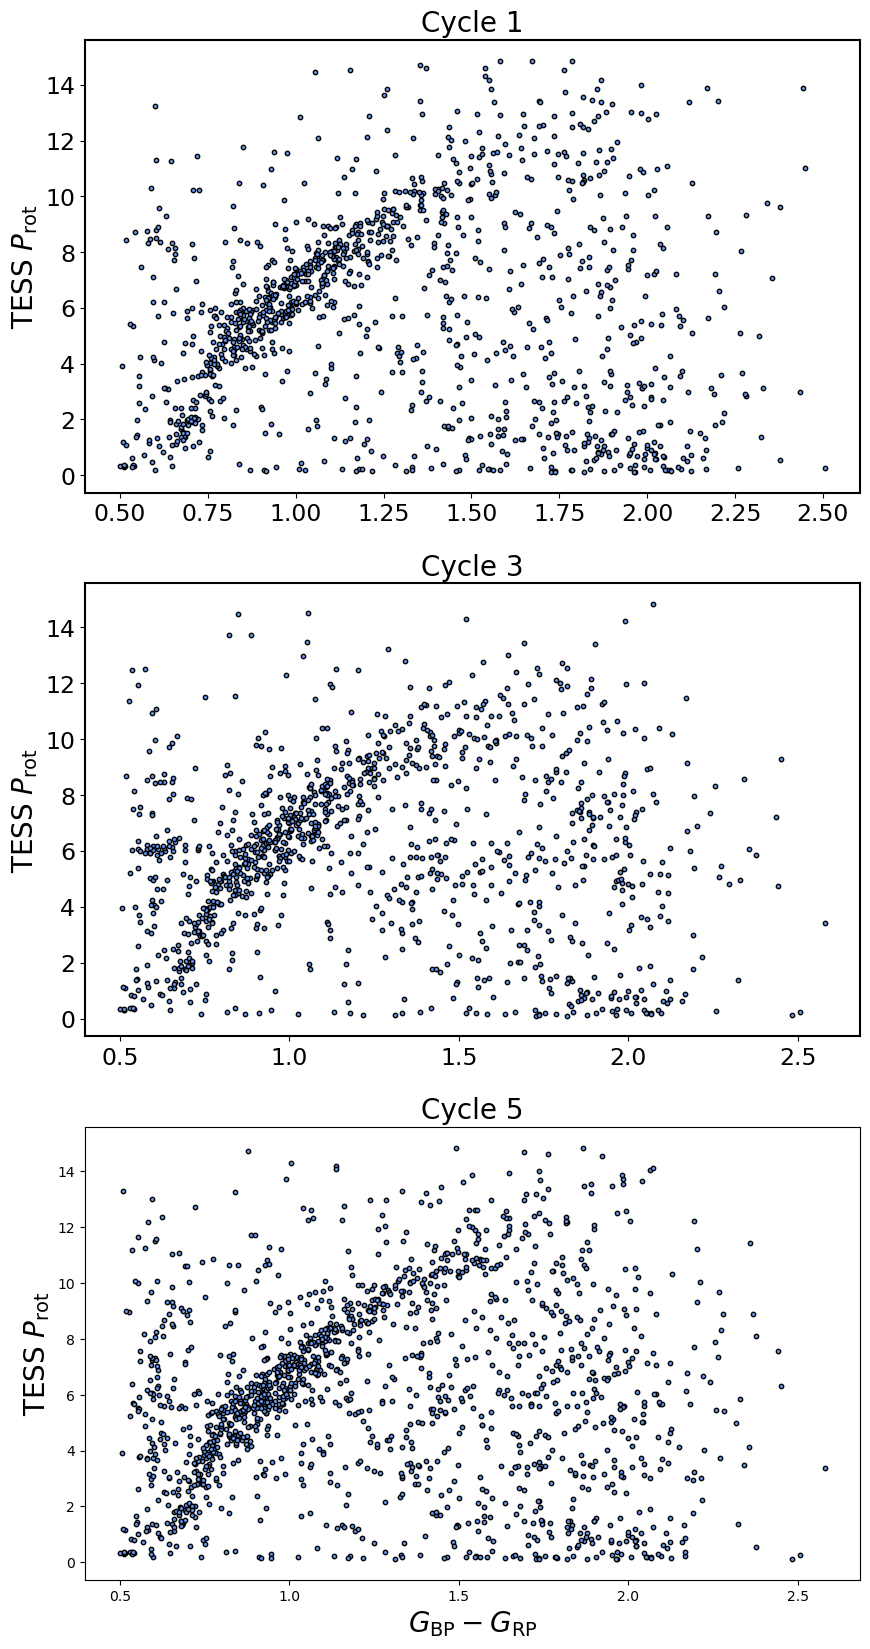

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10, 20))

#ax1.axhline(y = 3.5)
#ax1.axhline(y = 3)


ax1.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle1'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax1.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax1.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax1.set_title('Cycle 1', fontsize = 20)

ax2.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle3'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax2.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax2.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax2.set_title('Cycle 3', fontsize = 20)

ax3.scatter(full_catalog['bp_rp'], quality_period_table['LS_Period_Cycle5'], c = 'cornflowerblue', edgecolor = 'black', s = 10)
ax3.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
ax3.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax3.set_title('Cycle 5', fontsize = 20)

# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "Full_Member_CP_H_B.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)


plt.show()

**Find where measurements agree between cycles**

Targets will be sorted into classes based on how many quality period measurements they have. Class 1 stars have three periods in agreement, Class 2 stars have two periods in agreement, and Class 3 stars have one quality period.

In [31]:
cycle1 = 0
cycle3 = 0
cycle5 = 0

cycle13 = 0
cycle15 = 0
cycle35 = 0

cycle135 = 0

cycle1_only = 0
cycle3_only = 0
cycle5_only = 0

for i in range(0, len(full_catalog)):
  if(np.isnan(quality_period_table['LS_Period_Cycle1'][i]) == False):
    cycle1 += 1
    if(np.isnan(quality_period_table['LS_Period_Cycle3'][i]) == False and np.isnan(quality_period_table['LS_Period_Cycle5'][i]) == False):
      cycle135 += 1

      prots = (quality_period_table['LS_Period_Cycle1'][i], quality_period_table['LS_Period_Cycle3'][i], quality_period_table['LS_Period_Cycle5'][i])
      powers = (full_catalog['LS_Power_Cycle1'][i], quality_period_table['LS_Power_Cycle3'][i], quality_period_table['LS_Power_Cycle5'][i])
      per_diff = ((abs(quality_period_table['LS_Period_Cycle1'][i] - np.median(prots))/np.median(prots))*100, (abs(quality_period_table['LS_Period_Cycle3'][i] - np.median(prots))/np.median(prots))*100, (abs(quality_period_table['LS_Period_Cycle5'][i] - np.median(prots))/np.median(prots))*100)

      matching = 0

      for j in per_diff:
        if j < 20:
          matching += 1

      if(matching == 3):
        quality_period_table['Prot_Final'][i] = np.median(prots)
        quality_period_table['Power_Final'][i] = max(powers)
        quality_period_table['Class'][i] = 1

      elif(matching == 2):
        quality_period_table['Class'][i] = 2
        if((abs(prots[0] - prots[1])/prots[1])*100 < 20 or (abs(prots[1] - prots[0])/prots[0])*100 < 20):
          quality_period_table['Prot_Final'][i] = np.mean([prots[0], prots[1]])
          quality_period_table['Power_Final'][i] = max([powers[0], powers[1]])
        elif((abs(prots[1] - prots[2])/prots[2])*100 < 20 or (abs(prots[2] - prots[1])/prots[1])*100 < 20):
          quality_period_table['Prot_Final'][i] = np.mean([prots[1], prots[2]])
          quality_period_table['Power_Final'][i] = max([powers[1], powers[2]])
        elif((abs(prots[0] - prots[2])/prots[2])*100 < 20 or (abs(prots[2] - prots[0])/prots[0])*100 < 20):
          quality_period_table['Prot_Final'][i] = np.mean([prots[0], prots[2]])
          quality_period_table['Power_Final'][i] = max([powers[0], powers[2]])

      else:
        quality_period_table['Class'][i] = 3
        if(max(powers) == powers[0]):
          quality_period_table['Prot_Final'][i] = prots[0]
          quality_period_table['Power_Final'][i] = powers[0]
        elif(max(powers) == powers[1]):
          quality_period_table['Prot_Final'][i] = prots[1]
          quality_period_table['Power_Final'][i] = powers[1]
        elif(max(powers) == powers[1]):
          quality_period_table['Prot_Final'][i] = prots[2]
          quality_period_table['Power_Final'][i] = powers[2]



    elif(np.isnan(quality_period_table['LS_Period_Cycle3'][i]) == False):
      cycle13 += 1

      prots = (quality_period_table['LS_Period_Cycle1'][i], quality_period_table['LS_Period_Cycle3'][i])
      powers = (full_catalog['LS_Power_Cycle1'][i], quality_period_table['LS_Power_Cycle3'][i])
      per_diff = ((abs(prots[0] - prots[1]))/prots[1])*100

      if(per_diff < 20):
        quality_period_table['Prot_Final'][i] = np.mean(prots)
        quality_period_table['Power_Final'][i] = max(powers)
        quality_period_table['Class'][i] = 2

      else:
        quality_period_table['Class'][i] = 3
        if(max(powers) == powers[0]):
          quality_period_table['Prot_Final'][i] = prots[0]
          quality_period_table['Power_Final'][i] = max(powers)
        elif(max(powers) == powers[1]):
          quality_period_table['Prot_Final'][i] = prots[1]
          quality_period_table['Power_Final'][i] = max(powers)



    elif(np.isnan(quality_period_table['LS_Period_Cycle5'][i]) == False):
      cycle15 += 1


      prots = (quality_period_table['LS_Period_Cycle1'][i], quality_period_table['LS_Period_Cycle5'][i])
      powers = (full_catalog['LS_Power_Cycle1'][i], quality_period_table['LS_Power_Cycle5'][i])
      per_diff = ((abs(prots[0] - prots[1]))/prots[1])*100

      if(per_diff < 20):
        quality_period_table['Prot_Final'][i] = np.mean(prots)
        quality_period_table['Power_Final'][i] = max(powers)
        quality_period_table['Class'][i] = 2

      else:
        quality_period_table['Class'][i] = 3
        if(max(powers) == powers[0]):
          quality_period_table['Prot_Final'][i] = prots[0]
          quality_period_table['Power_Final'][i] = max(powers)
        elif(max(powers) == powers[1]):
          quality_period_table['Prot_Final'][i] = prots[1]
          quality_period_table['Power_Final'][i] = max(powers)



    else:
      cycle1_only += 1
      quality_period_table['Class'][i] = 3
      quality_period_table['Prot_Final'][i] = quality_period_table['LS_Period_Cycle1'][i]
      quality_period_table['Power_Final'][i] = quality_period_table['LS_Power_Cycle1'][i]


  if(np.isnan(quality_period_table['LS_Period_Cycle3'][i]) == False):
    cycle3 += 1
    if(np.isnan(quality_period_table['LS_Period_Cycle5'][i]) == False and np.isnan(quality_period_table['LS_Period_Cycle1'][i])):
      cycle35 += 1


      prots = (quality_period_table['LS_Period_Cycle3'][i], quality_period_table['LS_Period_Cycle5'][i])
      powers = (full_catalog['LS_Power_Cycle3'][i], quality_period_table['LS_Power_Cycle5'][i])
      per_diff = ((abs(prots[0] - prots[1]))/prots[1])*100

      if(per_diff < 20):
        quality_period_table['Prot_Final'][i] = np.mean(prots)
        quality_period_table['Power_Final'][i] = max(powers)
        quality_period_table['Class'][i] = 2

      else:
        quality_period_table['Class'][i] = 3
        if(max(powers) == powers[0]):
          quality_period_table['Prot_Final'][i] = prots[0]
          quality_period_table['Power_Final'][i] = max(powers)
        elif(max(powers) == powers[1]):
          quality_period_table['Prot_Final'][i] = prots[1]
          quality_period_table['Power_Final'][i] = max(powers)


    elif(np.isnan(quality_period_table['LS_Period_Cycle5'][i]) and np.isnan(quality_period_table['LS_Period_Cycle1'][i])):
      cycle3_only += 1
      quality_period_table['Class'][i] = 3
      quality_period_table['Prot_Final'][i] = quality_period_table['LS_Period_Cycle3'][i]
      quality_period_table['Power_Final'][i] = quality_period_table['LS_Power_Cycle3'][i]
  if(np.isnan(quality_period_table['LS_Period_Cycle5'][i]) == False):
    cycle5 += 1
    if(np.isnan(quality_period_table['LS_Period_Cycle3'][i]) and np.isnan(quality_period_table['LS_Period_Cycle1'][i])):
      cycle5_only += 1
      quality_period_table['Class'][i] = 3
      quality_period_table['Prot_Final'][i] = quality_period_table['LS_Period_Cycle5'][i]
      quality_period_table['Power_Final'][i] = quality_period_table['LS_Power_Cycle5'][i]

print('Cycle 1 Periods total: ' + str(cycle1))
print('Cycle 3 Periods total: ' + str(cycle3))
print('Cycle 5 Periods total: ' + str(cycle5))

print('Cycle 1 & 3 Periods only: ' + str(cycle13))
print('Cycle 1 & 5 Periods only: ' + str(cycle15))
print('Cycle 3 & 5 Periods only: ' + str(cycle35))

print('Cycle 1, 3, & 5 Periods: ' + str(cycle135))

print('Cycle 1 Periods only: ' + str(cycle1_only))
print('Cycle 3 Periods only: ' + str(cycle3_only))
print('Cycle 5 Periods only: ' + str(cycle5_only))

Cycle 1 Periods total: 1255
Cycle 3 Periods total: 1192
Cycle 5 Periods total: 1575
Cycle 1 & 3 Periods only: 38
Cycle 1 & 5 Periods only: 332
Cycle 3 & 5 Periods only: 268
Cycle 1, 3, & 5 Periods: 853
Cycle 1 Periods only: 32
Cycle 3 Periods only: 33
Cycle 5 Periods only: 122


In [32]:
quality_period_table

LS_Period_Cycle1,LS_Period_Cycle3,LS_Period_Cycle5,LS_Power_Cycle1,LS_Power_Cycle3,LS_Power_Cycle5,Class,Prot_Final,Power_Final,Cycle1_Doubled,Cycle3_Doubled,Cycle5_Doubled,Cycle1_Slowed,Cycle3_Slowed,Cycle5_Slowed
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5.6322771267058425,5.381001104177192,5.217758215543319,0.2317698057758105,0.15027049258278008,0.18325065411056868,1.0,5.381001104177192,0.2317698057758105,0.0,0.0,0.0,0.0,0.0,0.0
nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.6108014255776041,0.6108014255776041,nan,0.4835234847673348,0.28067995692308595,nan,2.0,0.6108014255776041,0.4835234847673348,0.0,0.0,0.0,0.0,0.0,0.0
nan,10.10164200735063,nan,0.24020192969231444,0.026310468185345756,nan,3.0,10.10164200735063,0.026310468185345756,0.0,0.0,0.0,0.0,0.0,0.0
nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10.090122761348857,11.270993922431433,nan,0.5011250299565889,0.06260820208053743,0.019157342045253184,2.0,10.680558341890144,0.5011250299565889,0.0,0.0,0.0,0.0,0.0,0.0


Notice average power for period measurements drops off with each class.

In [33]:
class1 = np.where(quality_period_table['Class'] == 1)[0]
class2 = np.where(quality_period_table['Class'] == 2)[0]
class3 = np.where(quality_period_table['Class'] == 3)[0]

print(len(class1))
print(len(class2))
print(len(class3))

print(np.mean(quality_period_table['Power_Final'][class1]))
print(np.mean(quality_period_table['Power_Final'][class2]))
print(np.mean(quality_period_table['Power_Final'][class3]))

624
646
408
0.2501546824564503
0.13733793768138228
0.055098681991131195


**Plot CPDs for each class**

Notice the increasing scatter with each class.

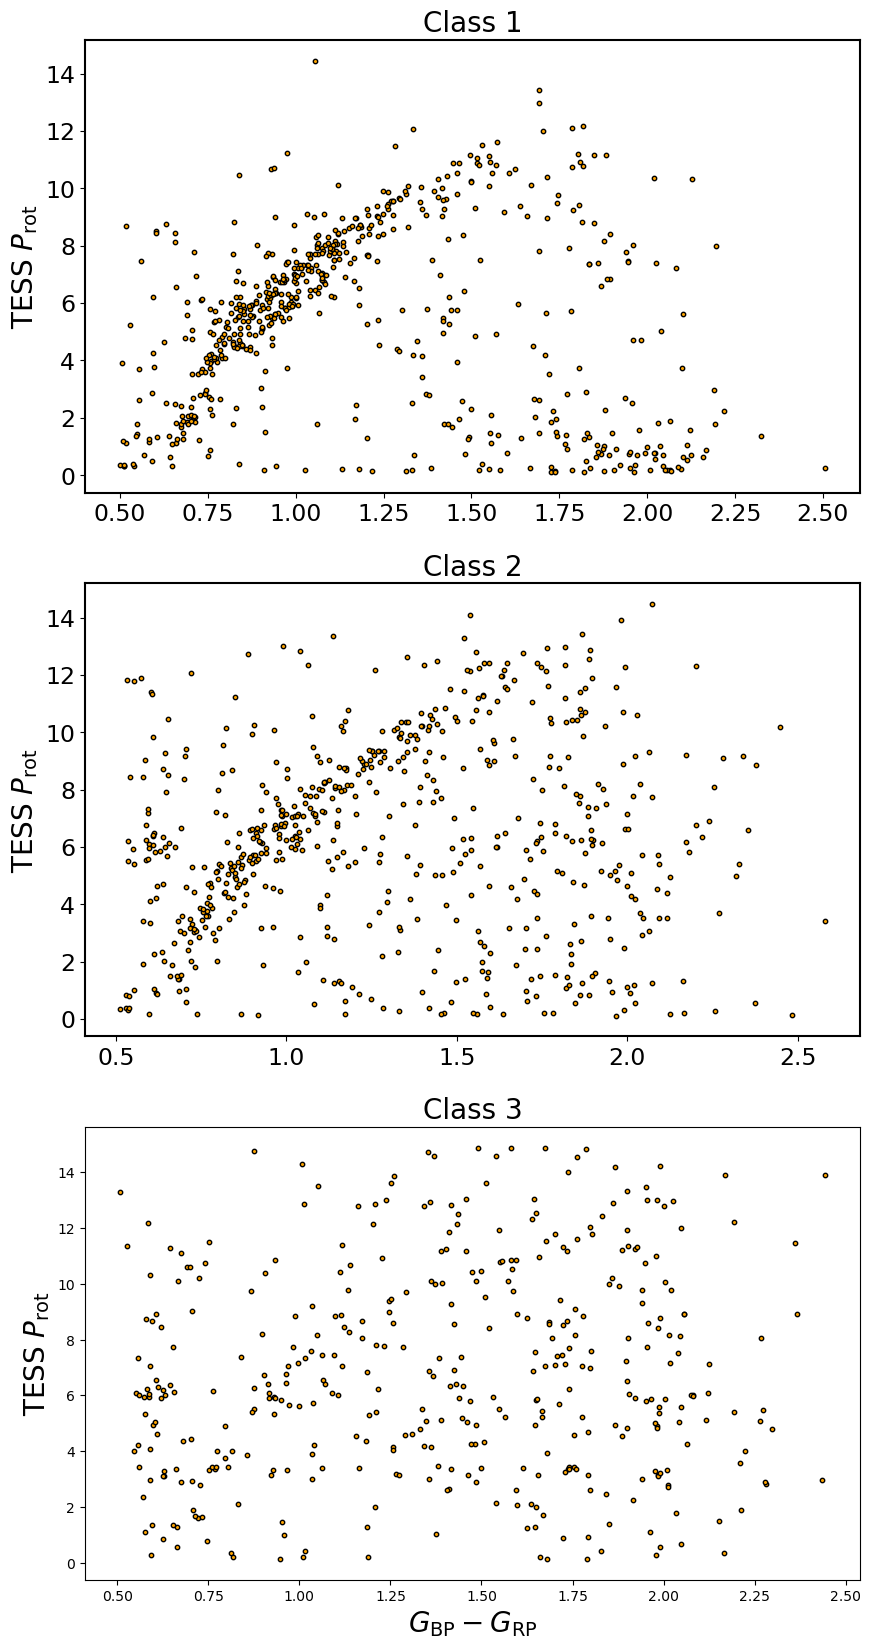

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10, 20))

#ax1.axhline(y = 3.5)
#ax1.axhline(y = 3)



ax1.scatter(full_catalog['bp_rp'][class1], quality_period_table['Prot_Final'][class1], c = 'orange', edgecolor = 'black', s = 10)
ax1.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax1.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax1.set_title('Class 1', fontsize = 20)

ax2.scatter(full_catalog['bp_rp'][class2], quality_period_table['Prot_Final'][class2], c = 'orange', edgecolor = 'black', s = 10)
ax2.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
#ax2.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax2.set_title('Class 2', fontsize = 20)

ax3.scatter(full_catalog['bp_rp'][class3], quality_period_table['Prot_Final'][class3], c = 'orange', edgecolor = 'black', s = 10)
ax3.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
ax3.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 20)
ax3.set_title('Class 3', fontsize = 20)

# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "Full_Member_CP_H_B.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)


plt.show()

**Plot classes together with filter for low power measurements**

In [35]:

for i in range(0, len(full_catalog)):

  if(quality_period_table['Prot_Final'][i] == 0):
    quality_period_table['Prot_Final'][i] = np.nan

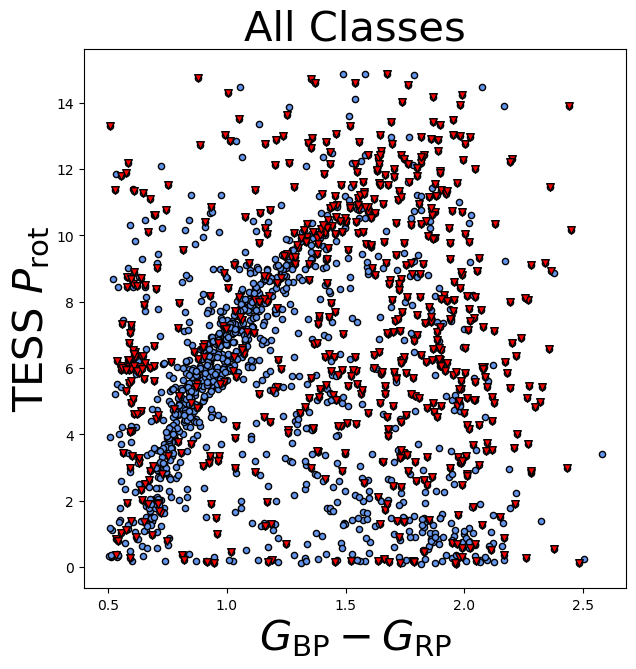

In [36]:

full_catalog['Power_Final'] = quality_period_table['Power_Final']
full_catalog['Prot_Final'] = quality_period_table['Prot_Final']
full_catalog['Class'] = quality_period_table['Class']

low_power = np.where(full_catalog['Power_Final'] < 0.05)[0]



fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(full_catalog['bp_rp'], full_catalog['Prot_Final'], c='cornflowerblue', edgecolor = 'black', s = 20)
#ax.scatter(full_catalog['bp_rp'][binary_candidates], full_catalog['Prot_Final'][binary_candidates], c='red', edgecolor = 'black', s = 30, marker = 'v')
#ax.scatter(full_catalog['bp_rp'][pm_outliers], full_catalog['Prot_Final'][pm_outliers], c='red', edgecolor = 'black', s = 30, marker = 'v')
#ax.scatter(full_catalog['bp_rp'][rv_outliers], full_catalog['Prot_Final'][rv_outliers], c='red', edgecolor = 'black', s = 30, marker = 'v')
#ax.scatter(full_catalog['bp_rp'][plx_outliers], full_catalog['Prot_Final'][plx_outliers], c='red', edgecolor = 'black', s = 30, marker = 'v')
ax.scatter(full_catalog['bp_rp'][low_power], full_catalog['Prot_Final'][low_power], c='red', edgecolor = 'black', s = 30, marker = 'v')
ax.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 30)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 30)
ax.set_title('All Classes', fontsize = 30)



# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "PM_Outliers_CPD.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)

902


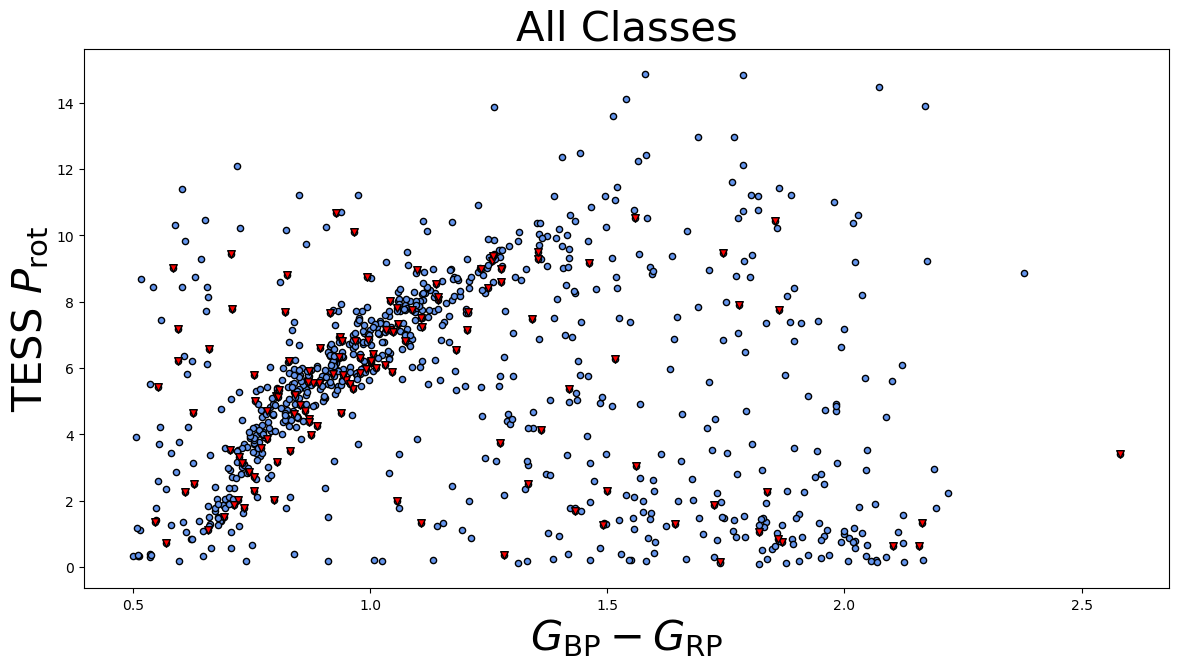

In [40]:
no_outliers = np.where((full_catalog['PM_Outlier'] == 0) & (full_catalog['Plx_Outlier'] == 0) & (full_catalog['RV_Outlier'] == 0)
 & (full_catalog['Power_Final'] > 0.05))[0]

# Binary candidates marked in red

binary_index = np.where((full_catalog['PM_Outlier'] == 0) & (full_catalog['Plx_Outlier'] == 0) & (full_catalog['RV_Outlier'] == 0)
 & (full_catalog['Power_Final'] > 0.05) & (full_catalog['Binary_Candidate'] == 1) & (full_catalog['Class'] != 3))[0]

print(len(no_outliers))

fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(full_catalog['bp_rp'][no_outliers], full_catalog['Prot_Final'][no_outliers], c='cornflowerblue', edgecolor = 'black', s = 20)
ax.scatter(full_catalog['bp_rp'][binary_index], full_catalog['Prot_Final'][binary_index], c='red', edgecolor = 'black', s = 30, marker = 'v')
ax.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 30)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 30)
ax.set_title('All Classes', fontsize = 30)



# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "PM_Outliers_CPD.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)

**Literature Comparison**

In [41]:
vizier_code = 'J/A+A/652/A60/table2'

query_catalog = Vizier()

query_catalog.ROW_LIMIT = -1

dario_rot = query_catalog.get_catalogs(vizier_code)[0]

dario_rot


ID,GaiaDR2,CLHW,RA_ICRS,DE_ICRS,__B-V_0,Vmag,__V-Ks_0,Prot,e_Prot,P90,Class,Binary,Simbad,_RA.icrs,_DE.icrs
,,,deg,deg,mag,mag,mag,d,d,mag,,,,deg,deg
str20,int64,int32,float64,float64,float32,float32,float32,float32,float32,float32,uint8,uint8,str6,float64,float64
618539,5339401641913283072,13824,167.35092,-58.72761,0.821,14.324,1.876,6.3962,0.9555,0.0284,3,0,Simbad,167.35092,-58.72761
618394,5339394323288436608,16353,167.33904,-58.81681,1.379,16.855,3.374,10.0044,0.2949,0.0190,3,0,Simbad,167.33904,-58.81681
618247,5339401126517113472,17842,167.32929,-58.76006,1.284,16.197,3.098,12.9536,0.1203,0.0158,3,0,Simbad,167.32929,-58.76006
615275,5340152230387020288,36499,167.22421,-58.68867,1.274,16.283,3.045,10.7061,2.7941,0.0200,3,0,Simbad,167.22421,-58.68867
614931,5340152848862460928,37931,167.21496,-58.62111,0.650,13.378,1.456,5.8337,0.4992,0.0340,3,0,Simbad,167.21496,-58.62111
608606,5340153226819389952,66890,167.06008,-58.65322,0.676,13.384,1.757,5.4437,0.3331,0.0250,3,1,Simbad,167.06008,-58.65322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807861,5338708812138803200,281762,165.72833,-58.62081,1.154,16.042,2.983,0.7333,0.0007,0.0458,2,0,Simbad,165.72833,-58.62081


In [42]:
full_catalog['Dario_Class'] = np.zeros(len(full_catalog)) - 1

for i in range(0, len(dario_rot)):
  distances = dist_form_arr(dario_rot['RA_ICRS'][i],dario_rot['DE_ICRS'][i],full_catalog['RA'],full_catalog['Dec'])
  xmatch_index = np.where(distances < 1)[0]
  full_catalog['Prot'][xmatch_index] = dario_rot['Prot'][i]
  full_catalog['Dario_Class'][xmatch_index] = dario_rot['Class'][i]

In [49]:
ascii.write(full_catalog, 'NGC_3532_catalog.csv', format = 'csv', overwrite = True)

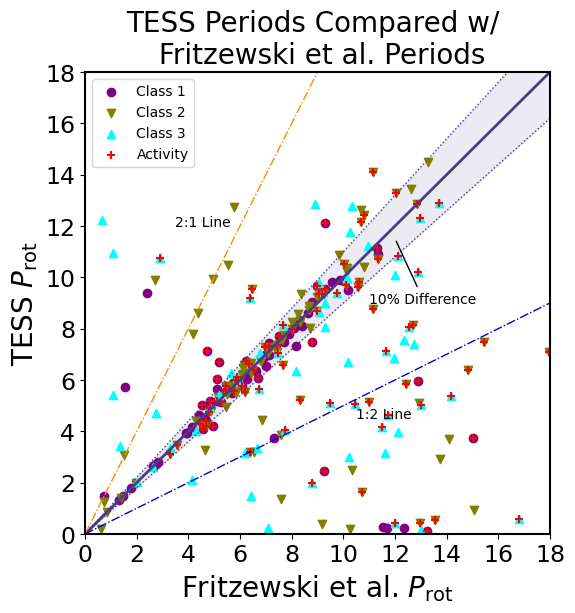

In [45]:
x = np.linspace(0, 18, 100)
y_half = x*0.5
y_plus_err = x + x*0.1
y_minus_err = x - x*0.1
y_double = x*2

binary = np.where(full_catalog['Binary_Candidate'] == 1
#& (full_catalog['Power_Final']>0.05) 
#& (full_catalog['PM_Outlier']==0) 
#& (full_catalog['RV_Outlier']==0) 
#& (full_catalog['Plx_Outlier']==0)
)[0]

class1 = np.where((full_catalog['Class'] == 1) 
#& (full_catalog['Power_Final']>0.05) 
#& (full_catalog['PM_Outlier']==0) 
#& (full_catalog['RV_Outlier']==0) 
#& (full_catalog['Plx_Outlier']==0)
)[0]

class2 = np.where((full_catalog['Class'] == 2) 
#& (full_catalog['Power_Final']>0.05) 
#& (full_catalog['PM_Outlier']==0) 
#& (full_catalog['RV_Outlier']==0) 
#& (full_catalog['Plx_Outlier']==0)
)[0]

class3 = np.where((full_catalog['Class'] == 3) 
#& (full_catalog['Power_Final']>0.05) 
#& (full_catalog['PM_Outlier']==0) 
#& (full_catalog['RV_Outlier']==0) 
#& (full_catalog['Plx_Outlier']==0)
)[0]

activity = np.where((full_catalog['Dario_Class'] == 3) 
#& (full_catalog['Power_Final']>0.05) 
#& (full_catalog['PM_Outlier']==0) 
#& (full_catalog['RV_Outlier']==0) 
#& (full_catalog['Plx_Outlier']==0)
)[0]




fig, axis = plt.subplots(figsize = (6,6))

axis.plot(x, x, c = 'darkslateblue', lw=2)
axis.plot(x, y_half, ls = '-.', lw=1, c = 'mediumblue')
axis.plot(x, y_double, c = 'darkorange', ls='-.', lw=1)

axis.fill_between(x, y_plus_err, y_minus_err, color = 'darkslateblue', alpha = 0.1)
axis.plot(x, y_plus_err, c = 'darkslateblue', linestyle = ':', lw=1)
axis.plot(x, y_minus_err, c = 'darkslateblue', linestyle = ':', lw=1)

axis.scatter(full_catalog['Prot'][class1], full_catalog['Prot_Final'][class1], c = 'purple', label = 'Class 1')
axis.scatter(full_catalog['Prot'][class2], full_catalog['Prot_Final'][class2], c = 'olive', label = 'Class 2', marker = 'v')
axis.scatter(full_catalog['Prot'][class3], full_catalog['Prot_Final'][class3], c = 'cyan', label = 'Class 3', marker = '^')
axis.scatter(full_catalog['Prot'][activity], full_catalog['Prot_Final'][activity], c = 'red', label = 'Activity', marker = '+')
#axis.scatter(full_catalog['Prot'][binary], full_catalog['Prot_Final'][binary], c = 'red', label = 'Binary', marker = '+')


axis.set_xlabel(r'Fritzewski et al. $P_{\rm rot}$', fontsize = 20)
axis.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 20)
axis.set_title('TESS Periods Compared w/ \n Fritzewski et al. Periods', fontsize = 20)

axis.set_xlim(0,18)
axis.set_ylim(0,18)


axis.annotate('10% Difference',xy = (12,11.5), xytext = (11, 9), arrowprops = dict(arrowstyle = '-'), fontsize = 10, fontweight = 'roman')
axis.annotate('2:1 Line',xy = (6, 12), xytext = (3.5, 12), fontsize = 10, fontweight = 'roman')
axis.annotate('1:2 Line',xy = (12, 6), xytext = (10.5, 4.5), fontsize = 10, fontweight = 'roman')

plt.xticks(range(0, 19, 2))
plt.yticks(range(0, 19, 2))

# Make pretty
axis.tick_params(axis='both', which='major', labelsize=legend_fontsize)
axis.spines['top'].set_linewidth(axis_width)
axis.spines['left'].set_linewidth(axis_width)
axis.spines['right'].set_linewidth(axis_width)
axis.spines['bottom'].set_linewidth(axis_width)
axis.legend(loc='upper left')

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "TESS_vs_Lit_Period.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)

plt.show()

In [46]:
count = 0

lit_stars = np.where((full_catalog['Dario_Class'] != -1) 
& (full_catalog['Prot_Final']>0)
& (full_catalog['Power_Final']>0.05) 
#& (full_catalog['PM_Outlier']==0) 
#& (full_catalog['RV_Outlier']==0) 
#& (full_catalog['Plx_Outlier']==0)
)[0]

print(len(lit_stars))

for i in lit_stars:
  if(full_catalog['Prot'][i]*1.2<full_catalog['Prot_Final'][i] or full_catalog['Prot'][i]*0.8>full_catalog['Prot_Final'][i]):
    count+=1

print(count)

162
41


**Plot CPD with literature comparison**

Vertical bars show seperation between TESS period and literature period. Red bars indicate a more rapid TESS period. Green bars indicate a more rapid literature period. Notice the persisting bias towards rapid measurements with TESS.

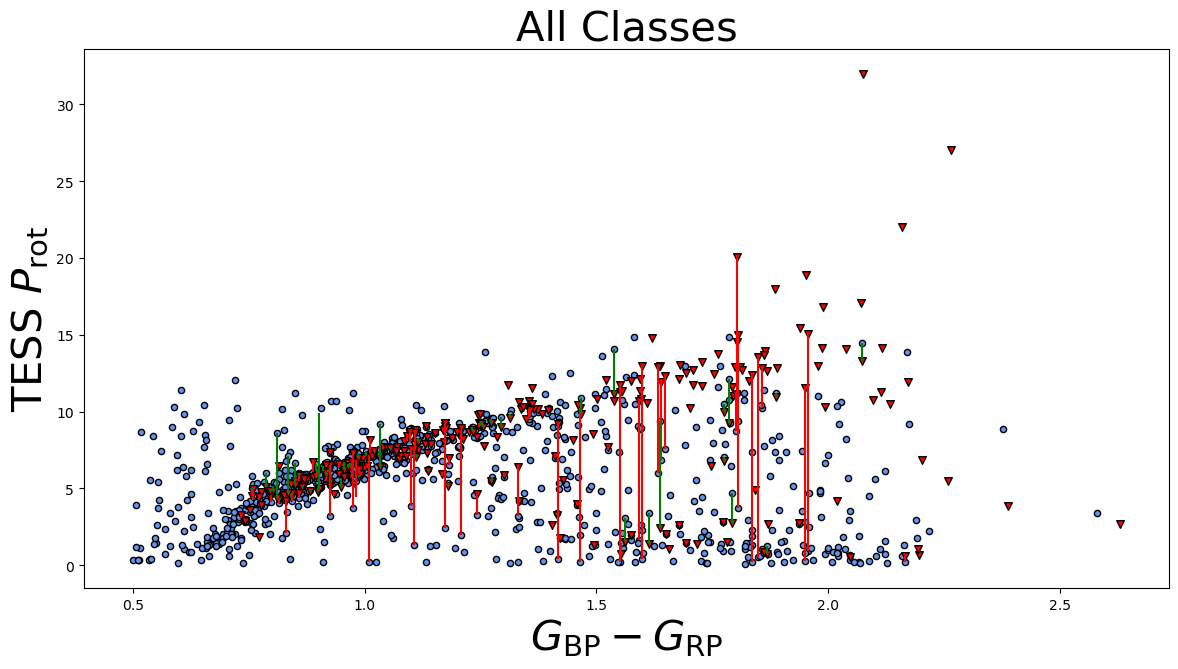

In [48]:


fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(full_catalog['bp_rp'][no_outliers], full_catalog['Prot_Final'][no_outliers], c='cornflowerblue', edgecolor = 'black', s = 20)
ax.scatter(full_catalog['bp_rp'], full_catalog['Prot'], c='red', edgecolor = 'black', s = 30, marker = 'v')
#ax.scatter(full_catalog['bp_rp'][binary_index], full_catalog['Prot_Final'][binary_index], c='yellow', edgecolor = 'black', s = 30, marker = 'v')
ax.set_ylabel(r'TESS $P_{\rm rot}$', fontsize = 30)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$', fontsize = 30)
ax.set_title('All Classes', fontsize = 30)

for i in lit_stars:
  if(full_catalog['Prot'][i]<full_catalog['Prot_Final'][i]):
    ax.vlines(full_catalog['bp_rp'][i], full_catalog['Prot'][i], full_catalog['Prot_Final'][i], color = 'green')
  elif(full_catalog['Prot'][i]>full_catalog['Prot_Final'][i]):
    ax.vlines(full_catalog['bp_rp'][i], full_catalog['Prot_Final'][i], full_catalog['Prot'][i], color = 'red')



# Make pretty
for ax in [ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=legend_fontsize)
  ax.spines['top'].set_linewidth(axis_width)
  ax.spines['left'].set_linewidth(axis_width)
  ax.spines['right'].set_linewidth(axis_width)
  ax.spines['bottom'].set_linewidth(axis_width)

# test if we are saving figures during this run
if save_plots == True:
  # create a file name
  file_name = dir_plots + "PM_Outliers_CPD.png"
  # save the figure
  fig.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)